# Let's Begin

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table, QTable
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from scipy.stats import norm
from scipy.optimize import linprog

from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u
import cmasher as cmr



import lmfit
from lmfit import minimize, Parameters,create_params,fit_report
from matplotlib.collections import LineCollection


from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [2]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.alpha = alpha
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + self.alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.2
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [3]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [ ]:
def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    y_NF =  Rings.y.copy()
    y_NF[back_ind] = -(Rings.y[back_ind] - y_offset )/ (Rings.y[back_ind].max() - y_offset)
    y_NF[fore_ind] = 1 - ((Rings.y[fore_ind] - np.nanmin(Rings.y[fore_ind]) )/ (y_offset-np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y>y_offset,y_NF,-(Rings.y - y_offset )/ (Rings.y[back_ind].max() - y_offset))
    #y_NF=np.where(Rings.y<=y_offset,y_NF,(Rings.y - np.nanmax(Rings.y[fore_ind]) )/ (np.nanmin(Rings.y[fore_ind]) - np.nanmax(Rings.y[fore_ind])))


    return back_ind, fore_ind, y_NF

def lb_lv_plots_postcolor_grad(Rings, out='None', scouse_on='None', output_save = 'None', IDs_on='None'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag
    IDtext_size = 20


    ### Plot Rings LB ###
    sgra = ax[0].scatter(-0.0558, -0.0462,marker = '*', s=150 ,color = 'k',zorder=10)
    ringcolor = ring_NF_dist_y(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    text_list = []
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)

        
        if IDs_on == True:
            key_clouds = np.array(['1','3','5','7a','9','10','13','14','16b','17b','19','20','21a','22','23','25'])
            if plot_cat_agg['leaf_id'][i] in key_clouds:
                if plot_cat_agg['b'][i] > -0.05:
                    text_list.append(ax[0].text(plot_cat_agg['l'][i]+0.04, plot_cat_agg['b'][i]+0.02,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
                else:
                    text_list.append(ax[0].text(plot_cat_agg['l'][i]+0.04, plot_cat_agg['b'][i]-0.045,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
    if IDs_on == True:

        t=np.where(key_clouds=='1')[0][0] #ID 1
        cat_t = np.where(plot_cat_agg['leaf_id']=='1')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.01, plot_cat_agg['b'][cat_t]+0.02, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='3')[0][0] #ID 3
        cat_t = np.where(plot_cat_agg['leaf_id']=='3')[0][0] #ID 3
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.0, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='9')[0][0] #ID 9
        cat_t = np.where(plot_cat_agg['leaf_id']=='9')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='10')[0][0] #ID 10
        cat_t = np.where(plot_cat_agg['leaf_id']=='10')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='13')[0][0] #ID 13
        cat_t = np.where(plot_cat_agg['leaf_id']=='13')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='14')[0][0] #ID 14
        cat_t = np.where(plot_cat_agg['leaf_id']=='14')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.02, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])
        
        t=np.where(key_clouds=='16b')[0][0] #ID 16
        cat_t = np.where(plot_cat_agg['leaf_id']=='16b')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.08, plot_cat_agg['b'][cat_t]-0.03, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='21a')[0][0] #ID 21
        cat_t = np.where(plot_cat_agg['leaf_id']=='21a')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.0, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='25')[0][0] #ID 21
        cat_t = np.where(plot_cat_agg['leaf_id']=='25')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.05, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])


    #ax[0].set_xlabel('longitude [deg]', labelpad=20)
    labelfontsize = 25
    ax[0].set_ylabel('latitude [deg]', labelpad=10, fontsize=labelfontsize)
    ax[0].set_xlim(0.95,-0.75)
    ax[0].set_ylim(-0.3,0.13)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist_y(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


        


    if scouse_on == True:
        l   = scouse_fits['l'].values
        b   = scouse_fits['b'].values
        v   = scouse_fits['velocity'].values
        amp = scouse_fits['amp'].values

        #ax[0].scatter(l, b, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
        #        norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)
        ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)


    ax[1].set_xlabel('longitude [deg]', labelpad=20, fontsize=labelfontsize)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10, fontsize=labelfontsize)

    ax[0].set_yticks(ticks = [-0.2, -0.1, 0.0, 0.1])
    ax[1].set_yticks(ticks = [-100, -50, 0, 50 , 100])
    ax[0].tick_params(axis='both', which='major', labelsize=labelfontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=labelfontsize)


    ax[1].set_xlim(.95,-.75)
    ax[1].set_ylim(-150,150)
    

    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)  
    if out =='None':
        ax[0].text(0.5, 3.3, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha), fontsize=20, ha='center', va='top', 
            transform=cax.transAxes)

    else:  
        ax[0].text(.5, 3.3, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha, out.redchi), fontsize=20, ha='center', va='top', 
            transform=cax.transAxes)
    
    #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   
    
    plt.show()





In [5]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

#scouse data for LV 
scouse_fits = pd.read_csv('../CMZ_datasets/final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/1393819246.py:1: SyntaxWarning: invalid escape sequence '\s'
  def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/1393819246.py:10: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+")


In [6]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='13')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='14')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

#post_A = post_tab['A_MC']
#post_mu = post_tab['mu_MC']
#post_sigma = post_tab['sigma_MC']

post_A = post_tab['A']
post_mu = post_tab['mu']
post_sigma = post_tab['sigma']
post_CI68 = post_tab['CI68']


## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [7]:
###Best Fitted Ellipses
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                    0.062 ,
                    0.021 ,
                    0.0118 ,
                    130.0 , 
                    np.radians(14.0),
                    xyzsun,vxyzsun,
                    alpha=0.18)


Rings_avg = Ring(phi,
                  0.086 ,
                  0.037 ,
                  0.0132 ,
                  116.73 , 
                  np.radians(20.8),
                  xyzsun,vxyzsun,
                  alpha=0.02)


Rings_outer = Ring(phi,
                    0.161 ,
                    0.066 ,
                    0.0149 ,
                    93.73 , 
                    np.radians(54.2),
                    xyzsun,vxyzsun,
                    alpha=0.18)



/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/1353431230.py:163: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


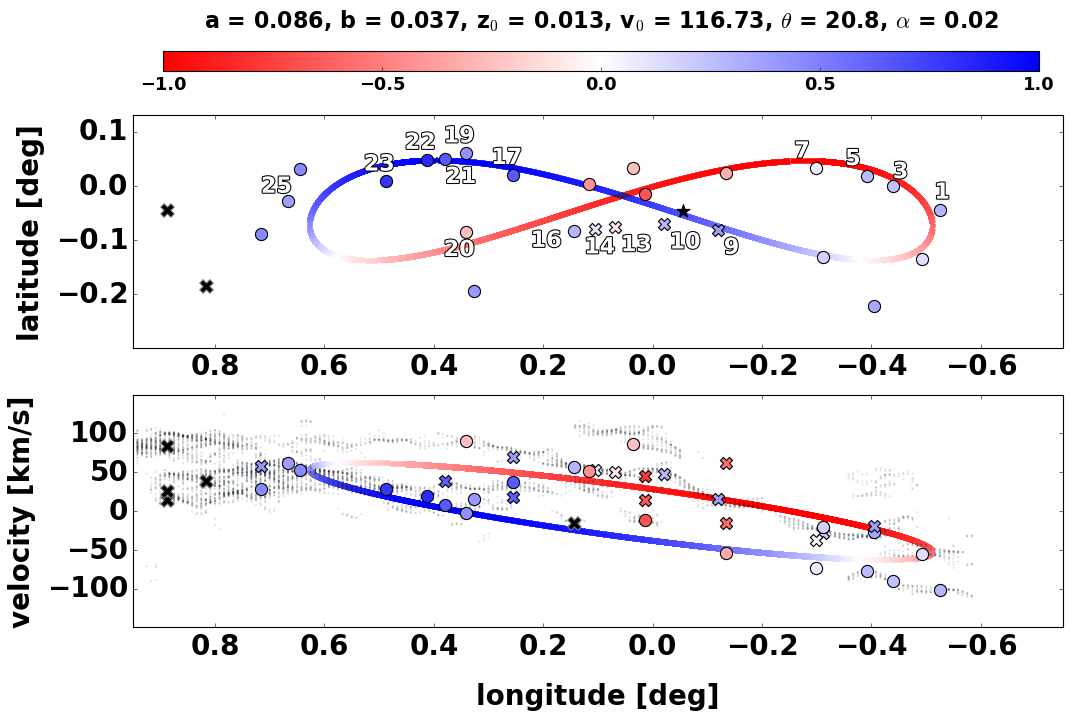

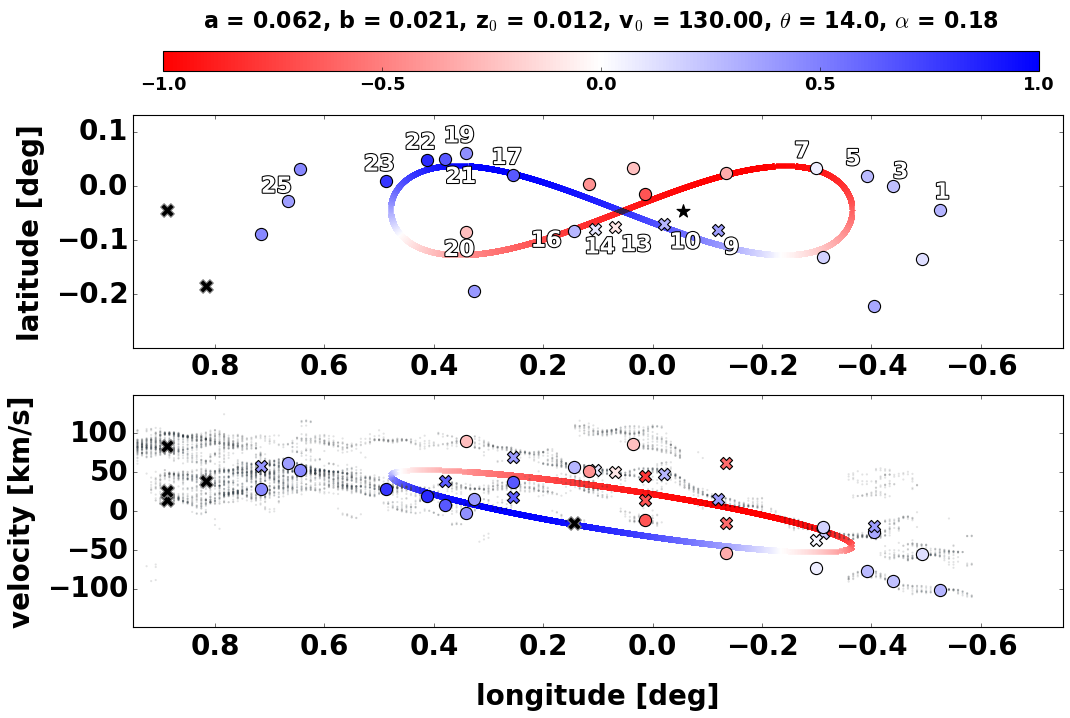

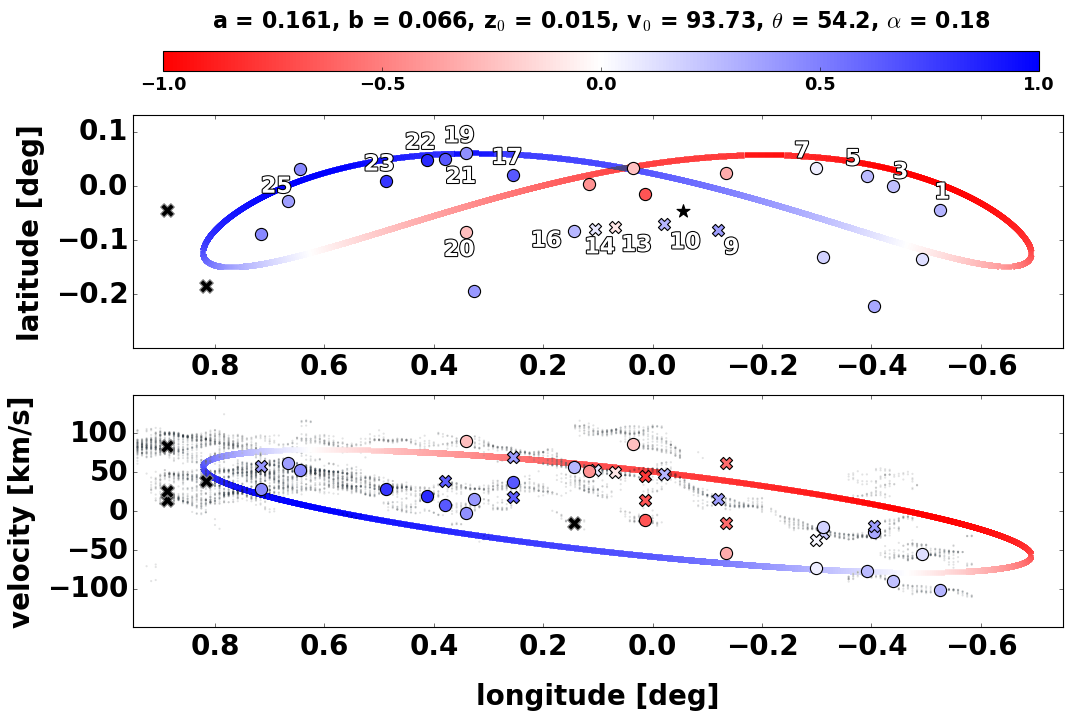

In [33]:
lb_lv_plots_postcolor_grad(Rings_avg, scouse_on=True, IDs_on =True)
lb_lv_plots_postcolor_grad(Rings_inner, scouse_on=True, IDs_on =True)
lb_lv_plots_postcolor_grad(Rings_outer, scouse_on=True, IDs_on =True)


In [ ]:
def lb_lv_plots_postcolor_grad_three(Rings,Rings_inner,Rings_outer, out='None', scouse_on='None', output_save = 'None', IDs_on='None'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))



    #plot inner and outer rings as dotted lines
    back_ind = np.where(Rings_inner.y>=y_offset)
    fore_ind = np.where(Rings_inner.y<=y_offset)

    ax[0].plot(np.degrees(Rings_inner.l[back_ind[0:-1]]),np.degrees(Rings_inner.b[back_ind[0:-1]]),c='red',linestyle='-',alpha=0.5)
    ax[0].plot(np.degrees(Rings_inner.l[fore_ind[0:]]),np.degrees(Rings_inner.b[fore_ind[0:]]),c='blue', linestyle = '-',linewidth=2, alpha=0.5, zorder=2)
    ax[1].plot(np.degrees(Rings_inner.l[back_ind[0:-1]]),Rings_inner.vr[back_ind[0:-1]],c='red',alpha=0.5)
    ax[1].plot(np.degrees(Rings_inner.l[fore_ind[0:]]),Rings_inner.vr[fore_ind[0:]],c='blue', linewidth=2, alpha=0.5, zorder=2)

    back_ind = np.where(Rings_outer.y>=y_offset)
    fore_ind = np.where(Rings_outer.y<=y_offset)

    ax[0].plot(np.degrees(Rings_outer.l[back_ind[0:-1]]),np.degrees(Rings_outer.b[back_ind[0:-1]]),c='red',linestyle='-',alpha=0.5)
    ax[0].plot(np.degrees(Rings_outer.l[fore_ind[0:]]),np.degrees(Rings_outer.b[fore_ind[0:]]),c='blue', linestyle = '-',linewidth=2, alpha=0.5, zorder=2)
    ax[1].plot(np.degrees(Rings_outer.l[back_ind[0:-1]]),Rings_outer.vr[back_ind[0:-1]],c='red',alpha=0.5)
    ax[1].plot(np.degrees(Rings_outer.l[fore_ind[0:]]),Rings_outer.vr[fore_ind[0:]],c='blue', linewidth=2, alpha=0.5, zorder=2)


    #plot avg ring as a bold line
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag


    ### Plot Rings LB ###
    sgra = ax[0].scatter(-0.0558, -0.0462,marker = '*', s=150 ,color = 'k',zorder=10)
    ringcolor = ring_NF_dist_y(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    text_list = []
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)

        
        if IDs_on == True:
            key_clouds = np.array(['1','3','5','7a','9','10','13','14','16b','17b','19','20','21a','22','23','25'])
            if plot_cat_agg['leaf_id'][i] in key_clouds:
                if plot_cat_agg['b'][i] > -0.05:
                    text_list.append(ax[0].text(plot_cat_agg['l'][i]+0.05, plot_cat_agg['b'][i]+0.02,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
                else:
                    text_list.append(ax[0].text(plot_cat_agg['l'][i]+0.05, plot_cat_agg['b'][i]-0.04,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
    if IDs_on == True:

        t=np.where(key_clouds=='1')[0][0] #ID 1
        cat_t = np.where(plot_cat_agg['leaf_id']=='1')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.01, plot_cat_agg['b'][cat_t]+0.02, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='3')[0][0] #ID 3
        cat_t = np.where(plot_cat_agg['leaf_id']=='3')[0][0] #ID 3
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.0, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='9')[0][0] #ID 9
        cat_t = np.where(plot_cat_agg['leaf_id']=='9')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.035, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='10')[0][0] #ID 10
        cat_t = np.where(plot_cat_agg['leaf_id']=='10')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.035, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='13')[0][0] #ID 13
        cat_t = np.where(plot_cat_agg['leaf_id']=='13')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.04, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='14')[0][0] #ID 14
        cat_t = np.where(plot_cat_agg['leaf_id']=='14')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.02, plot_cat_agg['b'][cat_t]-0.04, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])
        
        t=np.where(key_clouds=='16b')[0][0] #ID 16
        cat_t = np.where(plot_cat_agg['leaf_id']=='16b')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.08, plot_cat_agg['b'][cat_t]-0.03, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='21a')[0][0] #ID 21
        cat_t = np.where(plot_cat_agg['leaf_id']=='21a')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.0, plot_cat_agg['b'][cat_t]-0.035, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        t=np.where(key_clouds=='25')[0][0] #ID 21
        cat_t = np.where(plot_cat_agg['leaf_id']=='25')[0][0]
        text_list[t].remove()
        text_list[t]=ax[0].text(plot_cat_agg['l'][cat_t]+0.05, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])


    #ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.13)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist_y(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


        


    if scouse_on == True:
        l   = scouse_fits['l'].values
        b   = scouse_fits['b'].values
        v   = scouse_fits['velocity'].values
        amp = scouse_fits['amp'].values

        #ax[0].scatter(l, b, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
        #        norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)
        ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)  
    if out =='None':
        ax[0].text(0.5, 3.3, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha), fontsize=20, ha='center', va='top', 
            transform=cax.transAxes)

    else:  
        ax[0].text(.5, 3.3, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha, out.redchi), fontsize=20, ha='center', va='top', 
            transform=cax.transAxes)
    
    #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   
    
    plt.show()



/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/2467691917.py:168: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


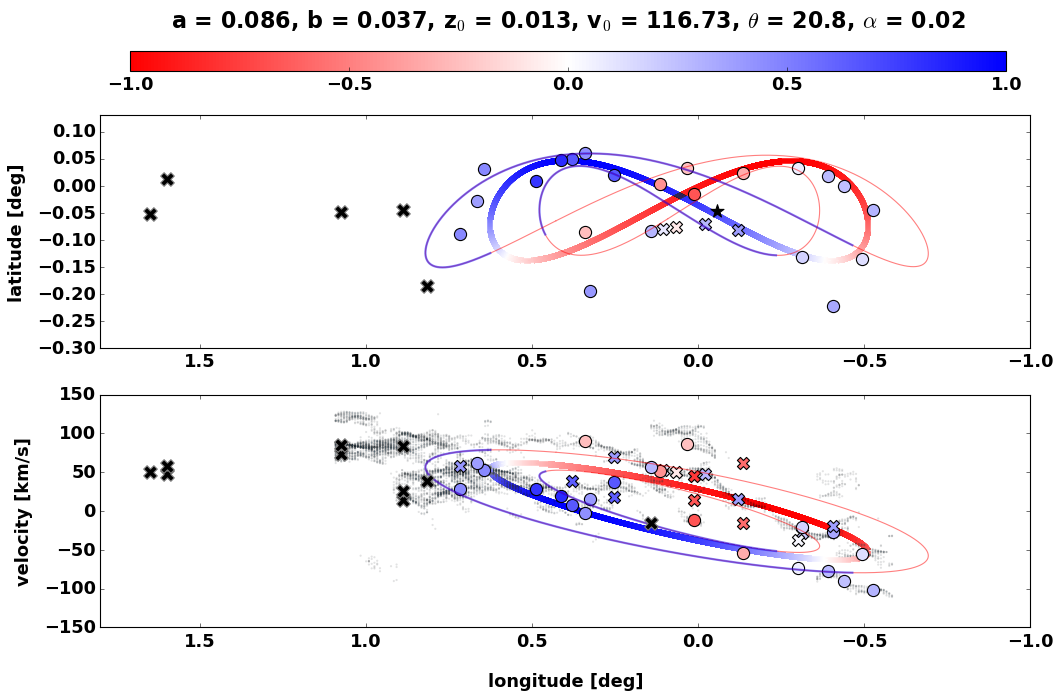

In [21]:
lb_lv_plots_postcolor_grad_three(Rings_avg, Rings_inner,Rings_outer, scouse_on=True, IDs_on =False)


# Gridspec 3X3

In [132]:
IDtext_size = 20
def lbv_nocax(Rings, ax, out='None', scouse_on='None', output_save = 'None', IDs_on='None', space='None'):

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    ringcmap = 'bwr_r' #cmr.prinsenvlag
    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    labelfontsize = 25

    if space =='lb':
        


        back_ind = np.where(Rings.y>=y_offset)
        fore_ind = np.where(Rings.y<=y_offset)
        
        
        


        ### Plot Rings LB ###
        sgra = ax.scatter(-0.0558, -0.0462,marker = '*', s=150 ,color = 'k',zorder=10)
        ringcolor = ring_NF_dist_y(Rings)[2]
        lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=1)


        
        text_list = []
        for i in range(0,len(plot_cat_agg)):

            if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
                marker = 'X'
                alpha = 1.
            else:
                marker = 'o'
                alpha =1.
                

            if plot_cat_agg['NF_decision'][i] != 'nan':
                sc = ax.scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                            c=plot_post_tab_agg['mu'][i], s=120, 
                            cmap=cmap, norm=divnorm, alpha = alpha)

            if plot_cat_agg['NF_decision'][i] == 'nan':
                ax.scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)

            
            if IDs_on == True:
                key_clouds = np.array(['1','3','5','7a','9','10','13','14','16b','17b','19','20','21a','22','23','25'])
                if plot_cat_agg['leaf_id'][i] in key_clouds:
                    if plot_cat_agg['b'][i] > -0.05:
                        text_list.append(ax.text(plot_cat_agg['l'][i]+0.04, plot_cat_agg['b'][i]+0.02,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
                    else:
                        text_list.append(ax.text(plot_cat_agg['l'][i]+0.04, plot_cat_agg['b'][i]-0.045,s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")]))
        if IDs_on == True:

            t=np.where(key_clouds=='1')[0][0] #ID 1
            cat_t = np.where(plot_cat_agg['leaf_id']=='1')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]+0.01, plot_cat_agg['b'][cat_t]+0.02, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size, weight='bold',path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='3')[0][0] #ID 3
            cat_t = np.where(plot_cat_agg['leaf_id']=='3')[0][0] #ID 3
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]-0.0, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='9')[0][0] #ID 9
            cat_t = np.where(plot_cat_agg['leaf_id']=='9')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='10')[0][0] #ID 10
            cat_t = np.where(plot_cat_agg['leaf_id']=='10')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='13')[0][0] #ID 13
            cat_t = np.where(plot_cat_agg['leaf_id']=='13')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]-0.01, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='14')[0][0] #ID 14
            cat_t = np.where(plot_cat_agg['leaf_id']=='14')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]+0.02, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])
            
            t=np.where(key_clouds=='16b')[0][0] #ID 16
            cat_t = np.where(plot_cat_agg['leaf_id']=='16b')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]+0.08, plot_cat_agg['b'][cat_t]-0.03, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='21a')[0][0] #ID 21
            cat_t = np.where(plot_cat_agg['leaf_id']=='21a')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]+0.0, plot_cat_agg['b'][cat_t]-0.045, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

            t=np.where(key_clouds=='25')[0][0] #ID 21
            cat_t = np.where(plot_cat_agg['leaf_id']=='25')[0][0]
            text_list[t].remove()
            text_list[t]=ax.text(plot_cat_agg['l'][cat_t]+0.05, plot_cat_agg['b'][cat_t]+0.015, s=int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][cat_t]))),color='w', fontsize=IDtext_size,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])

        #if out =='None':
        #    ax.text(0.5, 1.1, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha), fontsize=20, ha='center', va='top', 
        #    transform=ax.transAxes)

        #else:  
        #    ax.test(0.5, 1., r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha, out.redchi), fontsize=20, ha='center', va='top', 
        #    transform=ax.transAxes)

        #ax.set_xlabel('longitude [deg]', labelpad=20)
        
        ax.set_ylabel('latitude [deg]', labelpad=10, fontsize=labelfontsize)
        ax.set_yticks(ticks = [-0.2, -0.1, 0, 0.1, 0.2])

        #ax.set_xlabel('longitude [deg]', labelpad=20, fontsize=labelfontsize)
        ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
        ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
        ax.set_xlim(0.95,-0.75)
        ax.set_ylim(-0.3,0.13)



    if space =='lv':
        ### Plot Rings LV ###
        ringcolor = ring_NF_dist_y(Rings)[2]
        lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=1)

        #ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
        #ax.plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

        for i in range(0,len(plot_tab)):
            
            if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
                marker = 'X'
                alpha = 1.
            else:
                marker = 'o'
                alpha = 1.

            if plot_tab['NF_decision'][i] != 'nan':
                ax.scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                        c=plot_post_tab['mu'][i], s=120, 
                        cmap=cmap, norm=divnorm, alpha = alpha)


            if plot_tab['NF_decision'][i] == 'nan':
                ax.scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


            


        if scouse_on == True:
            l   = scouse_fits['l'].values
            b   = scouse_fits['b'].values
            v   = scouse_fits['velocity'].values
            amp = scouse_fits['amp'].values

            #ax.scatter(l, b, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
            #        norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)
            ax.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                    norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)


        #ax.set_xlabel('longitude [deg]', labelpad=20, fontsize=labelfontsize)
        ax.set_ylabel('velocity [km/s]', labelpad=10, fontsize=labelfontsize)

        ax.set_yticks(ticks = [-0.2, -0.1, 0.0, 0.1])
        ax.set_yticks(ticks = [-100, -50, 0, 50 , 100])
        ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
        ax.tick_params(axis='both', which='major', labelsize=labelfontsize)


        ax.set_xlim(.95,-.75)
        ax.set_ylim(-150,150)
        

        #cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
        #cb = plt.colorbar(sc, ax=ax, orientation='horizontal', cax=cax)  

        
        #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
        #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
        #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   



    return



/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/3295253311.py:164: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


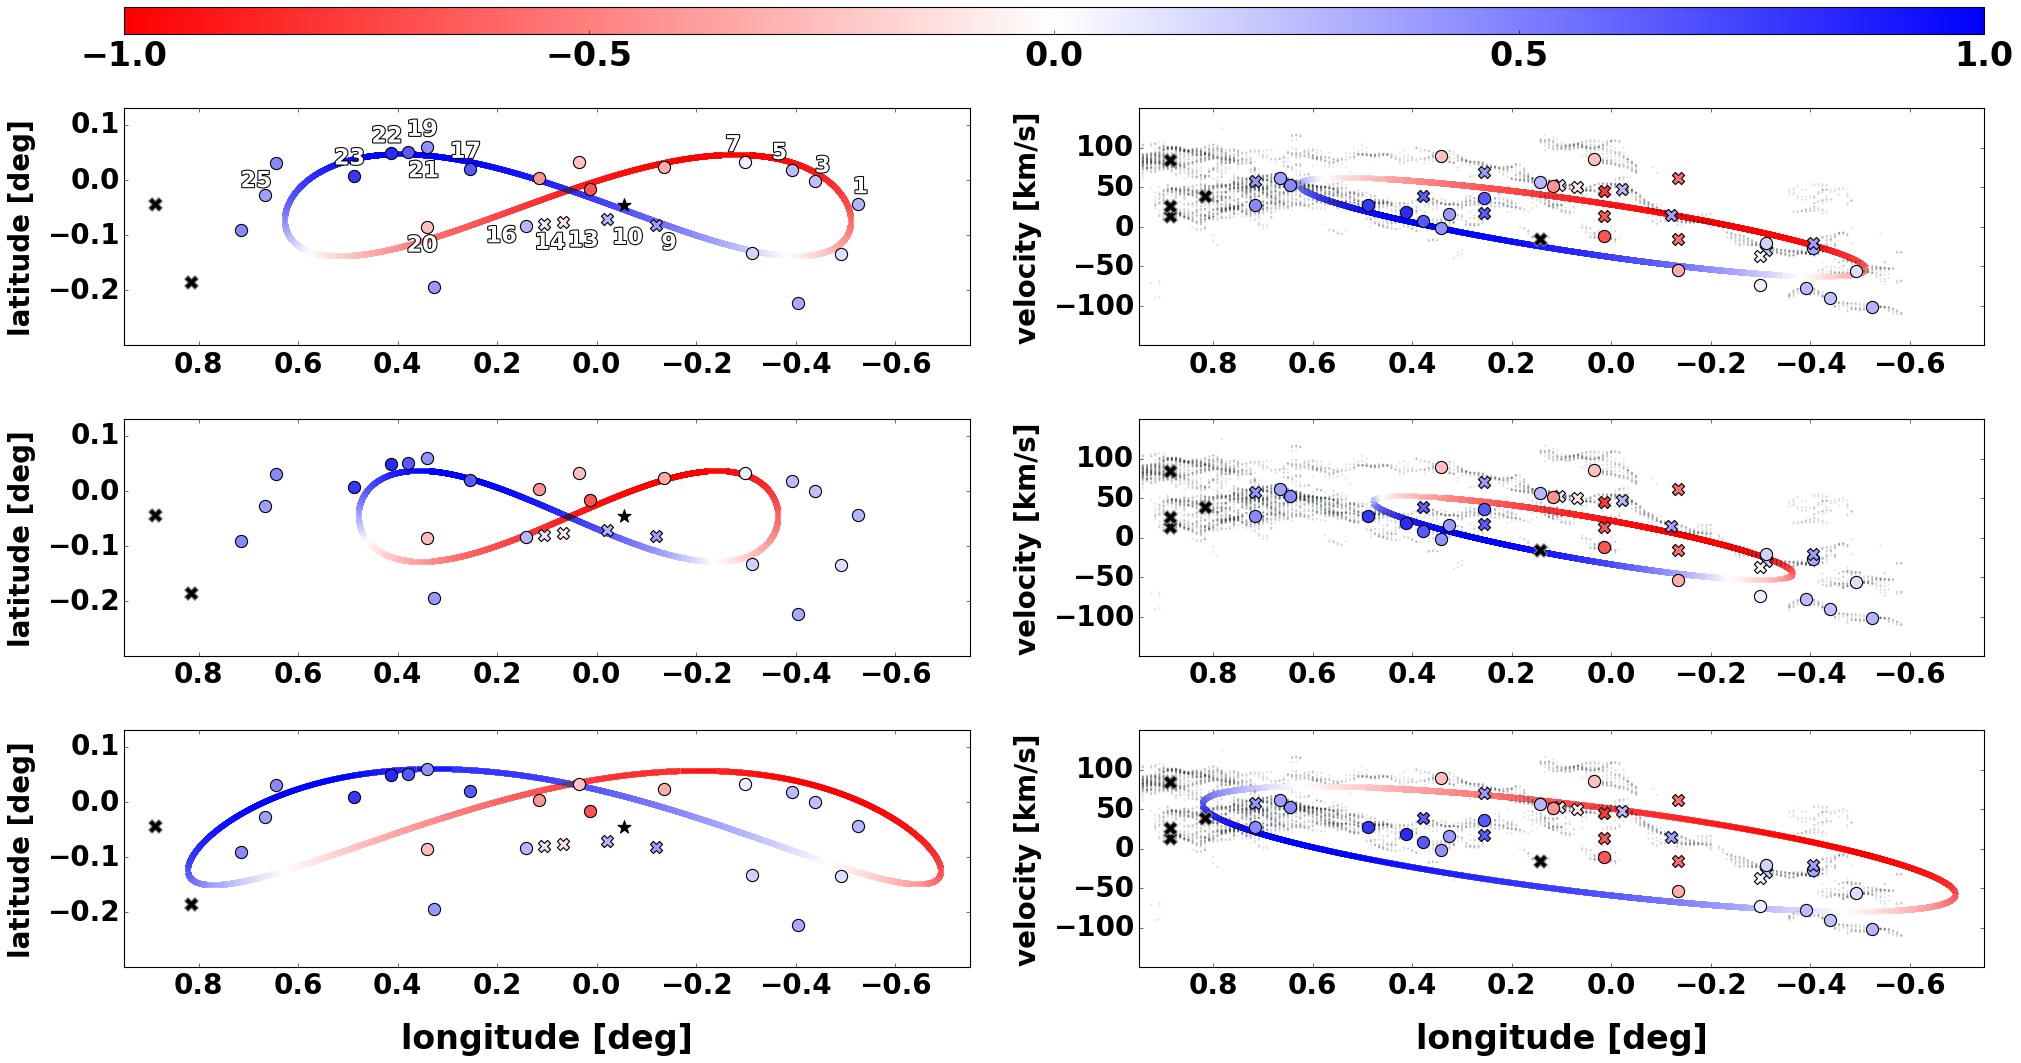

In [136]:
# Setup our Grid Speced plots
# Include an extra column between z and zoom for spacing
n_rows = 4
n_cols = 2

# 18 is more or less arbitrary,
# the ratio is important so that the imshow plots have 1:1 aspect ratio
width = 30
height_ratio = 0.5
fig = plt.figure(figsize=(width, width * height_ratio))
width_ratios = [1.0, 1.0]
height_ratios = [0.08, 0.7,0.7, 0.7]
gs1 = fig.add_gridspec(
    n_rows, n_cols,
    width_ratios = width_ratios,
    height_ratios = height_ratios,
    wspace = 0.2,
    hspace = 0.4,
)
cb_ax = fig.add_subplot(gs1[0, :])
lb1 = fig.add_subplot(gs1[1, 0])
lb2 = fig.add_subplot(gs1[2, 0])
lb3 = fig.add_subplot(gs1[3, 0])
lv1 = fig.add_subplot(gs1[1, 1])
lv2 = fig.add_subplot(gs1[2, 1])
lv3 = fig.add_subplot(gs1[3, 1])

lbv_nocax(Rings_avg, lb1, scouse_on=True, IDs_on =True, space='lb')
lbv_nocax(Rings_inner, lb2, scouse_on=True, IDs_on =False, space='lb')
lbv_nocax(Rings_outer, lb3, scouse_on=True, IDs_on =False, space='lb')


lbv_nocax(Rings_avg, lv1, scouse_on=True, IDs_on =True, space='lv')
lbv_nocax(Rings_inner, lv2, scouse_on=True, IDs_on =False, space='lv')
lbv_nocax(Rings_outer, lv3, scouse_on=True, IDs_on =False, space='lv')

lb3.set_xlabel('longitude [deg]', labelpad=20, fontsize=30)
lv3.set_xlabel('longitude [deg]', labelpad=20, fontsize=30)

ringcmap = 'bwr_r' #cmr.prinsenvlag
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=ringcmap, norm=divnorm),
    cax=cb_ax,
    orientation='horizontal'
)
cb.ax.tick_params(labelsize=30) 

plt.savefig('./paper_items/Figs/6panel_lblv_fittings.png', bbox_inches='tight', dpi=200)


# PPV?

In [138]:
def back_fore_ind(Rings):

    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    return back_ind, fore_ind

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/1088630573.py:24: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/1088630573.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=b_labels,
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/1088630573.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels=z_labels,


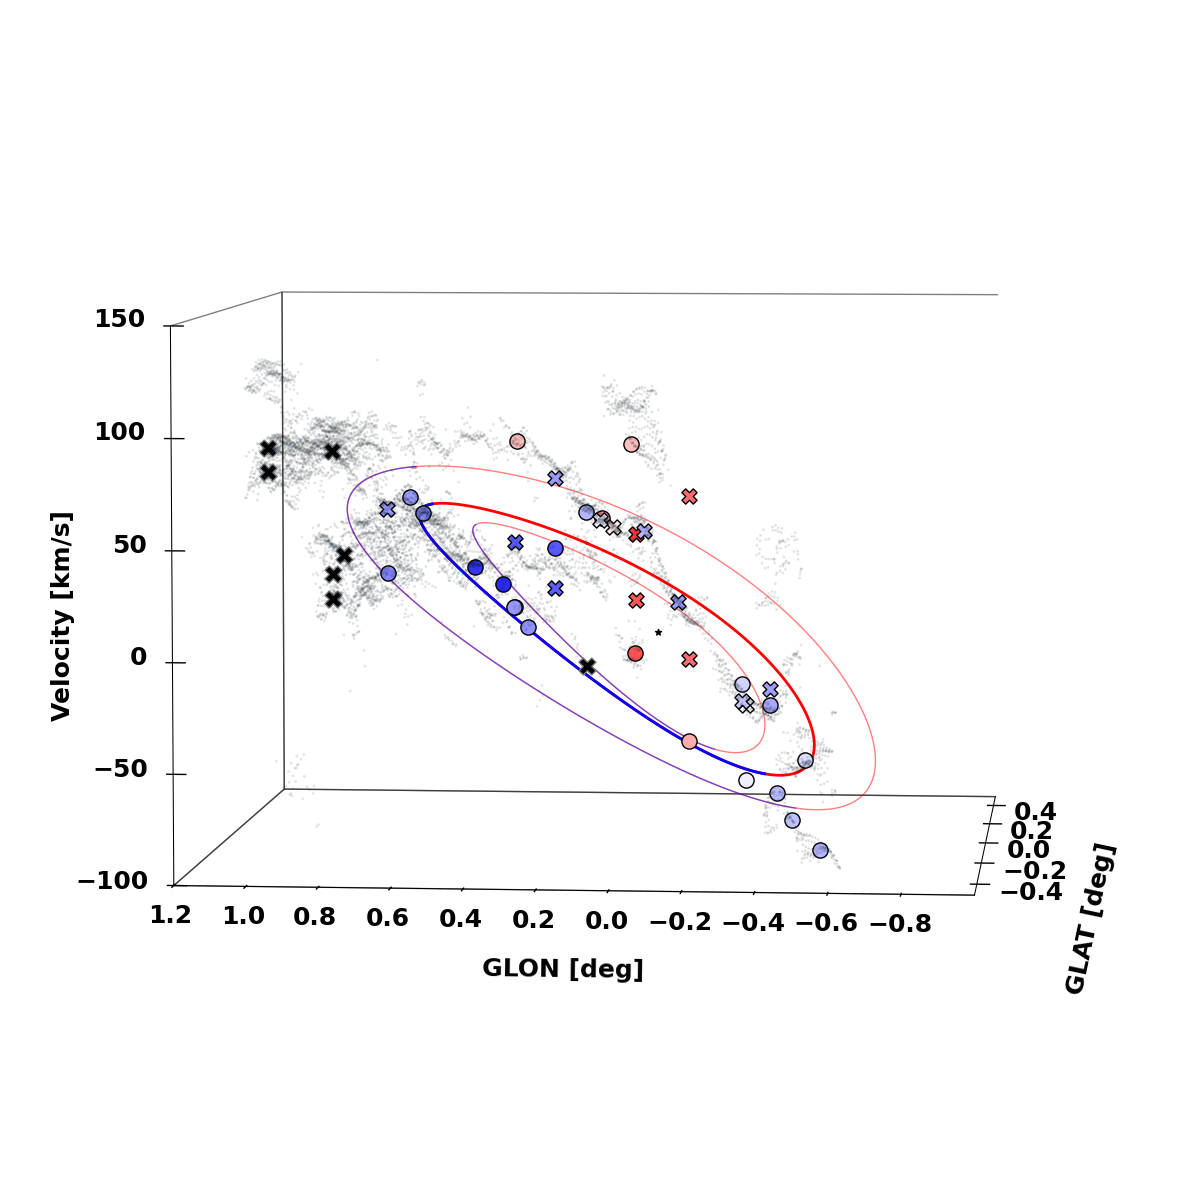

<Figure size 640x480 with 0 Axes>

In [54]:
fig = plt.figure(figsize=(15,15), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

back_ind, fore_ind = back_fore_ind(Rings_inner)
ax.plot(np.degrees(Rings_inner.l[back_ind[0:-1]]),np.degrees(Rings_inner.b[back_ind[0:-1]]), Rings_inner.vr[back_ind[0:-1]], ls='-', color='red', linewidth=1,  alpha=0.5)
ax.plot(np.degrees(Rings_inner.l[fore_ind[0:]]),np.degrees(Rings_inner.b[fore_ind[0:]]), Rings_inner.vr[fore_ind[0:]], ls='-', color='blue', linewidth=1,  alpha=0.5)


back_ind, fore_ind = back_fore_ind(Rings_avg)
ax.plot(np.degrees(Rings_avg.l[back_ind[0:-1]]),np.degrees(Rings_avg.b[back_ind[0:-1]]), Rings_avg.vr[back_ind[0:-1]], ls='-', color='red', linewidth=2, alpha=1)
ax.plot(np.degrees(Rings_avg.l[fore_ind[0:]]),np.degrees(Rings_avg.b[fore_ind[0:]]), Rings_avg.vr[fore_ind[0:]], ls='-', color='blue', linewidth=2,  alpha=1)


back_ind, fore_ind = back_fore_ind(Rings_outer)
ax.plot(np.degrees(Rings_outer.l[back_ind[0:-1]]),np.degrees(Rings_outer.b[back_ind[0:-1]]), Rings_outer.vr[back_ind[0:-1]], ls='-', color='red', linewidth=1, alpha=0.5)
ax.plot(np.degrees(Rings_outer.l[fore_ind[0:]]),np.degrees(Rings_outer.b[fore_ind[0:]]), Rings_outer.vr[fore_ind[0:]], ls='-', color='blue', linewidth=1,  alpha=0.5)







#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)








ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)

plt.savefig('./paper_items/Figs/PPV_3ellipse.png', bbox_inches='tight')

plt.show()

plt.clf()



/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/3973663441.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l[n_lv_mask], b[n_lv_mask], v[n_lv_mask], c=amp[n_lv_mask], cmap='Greys', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/3973663441.py:30: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l[lv_mask], b[lv_mask], v[lv_mask], c=amp[lv_mask], cmap='Greens', marker='o', s=1, facecolor='1', edgecolor='peru' ,norm=mpl.colors.LogNorm(), alpha=0.3)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_55361/3973663441.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

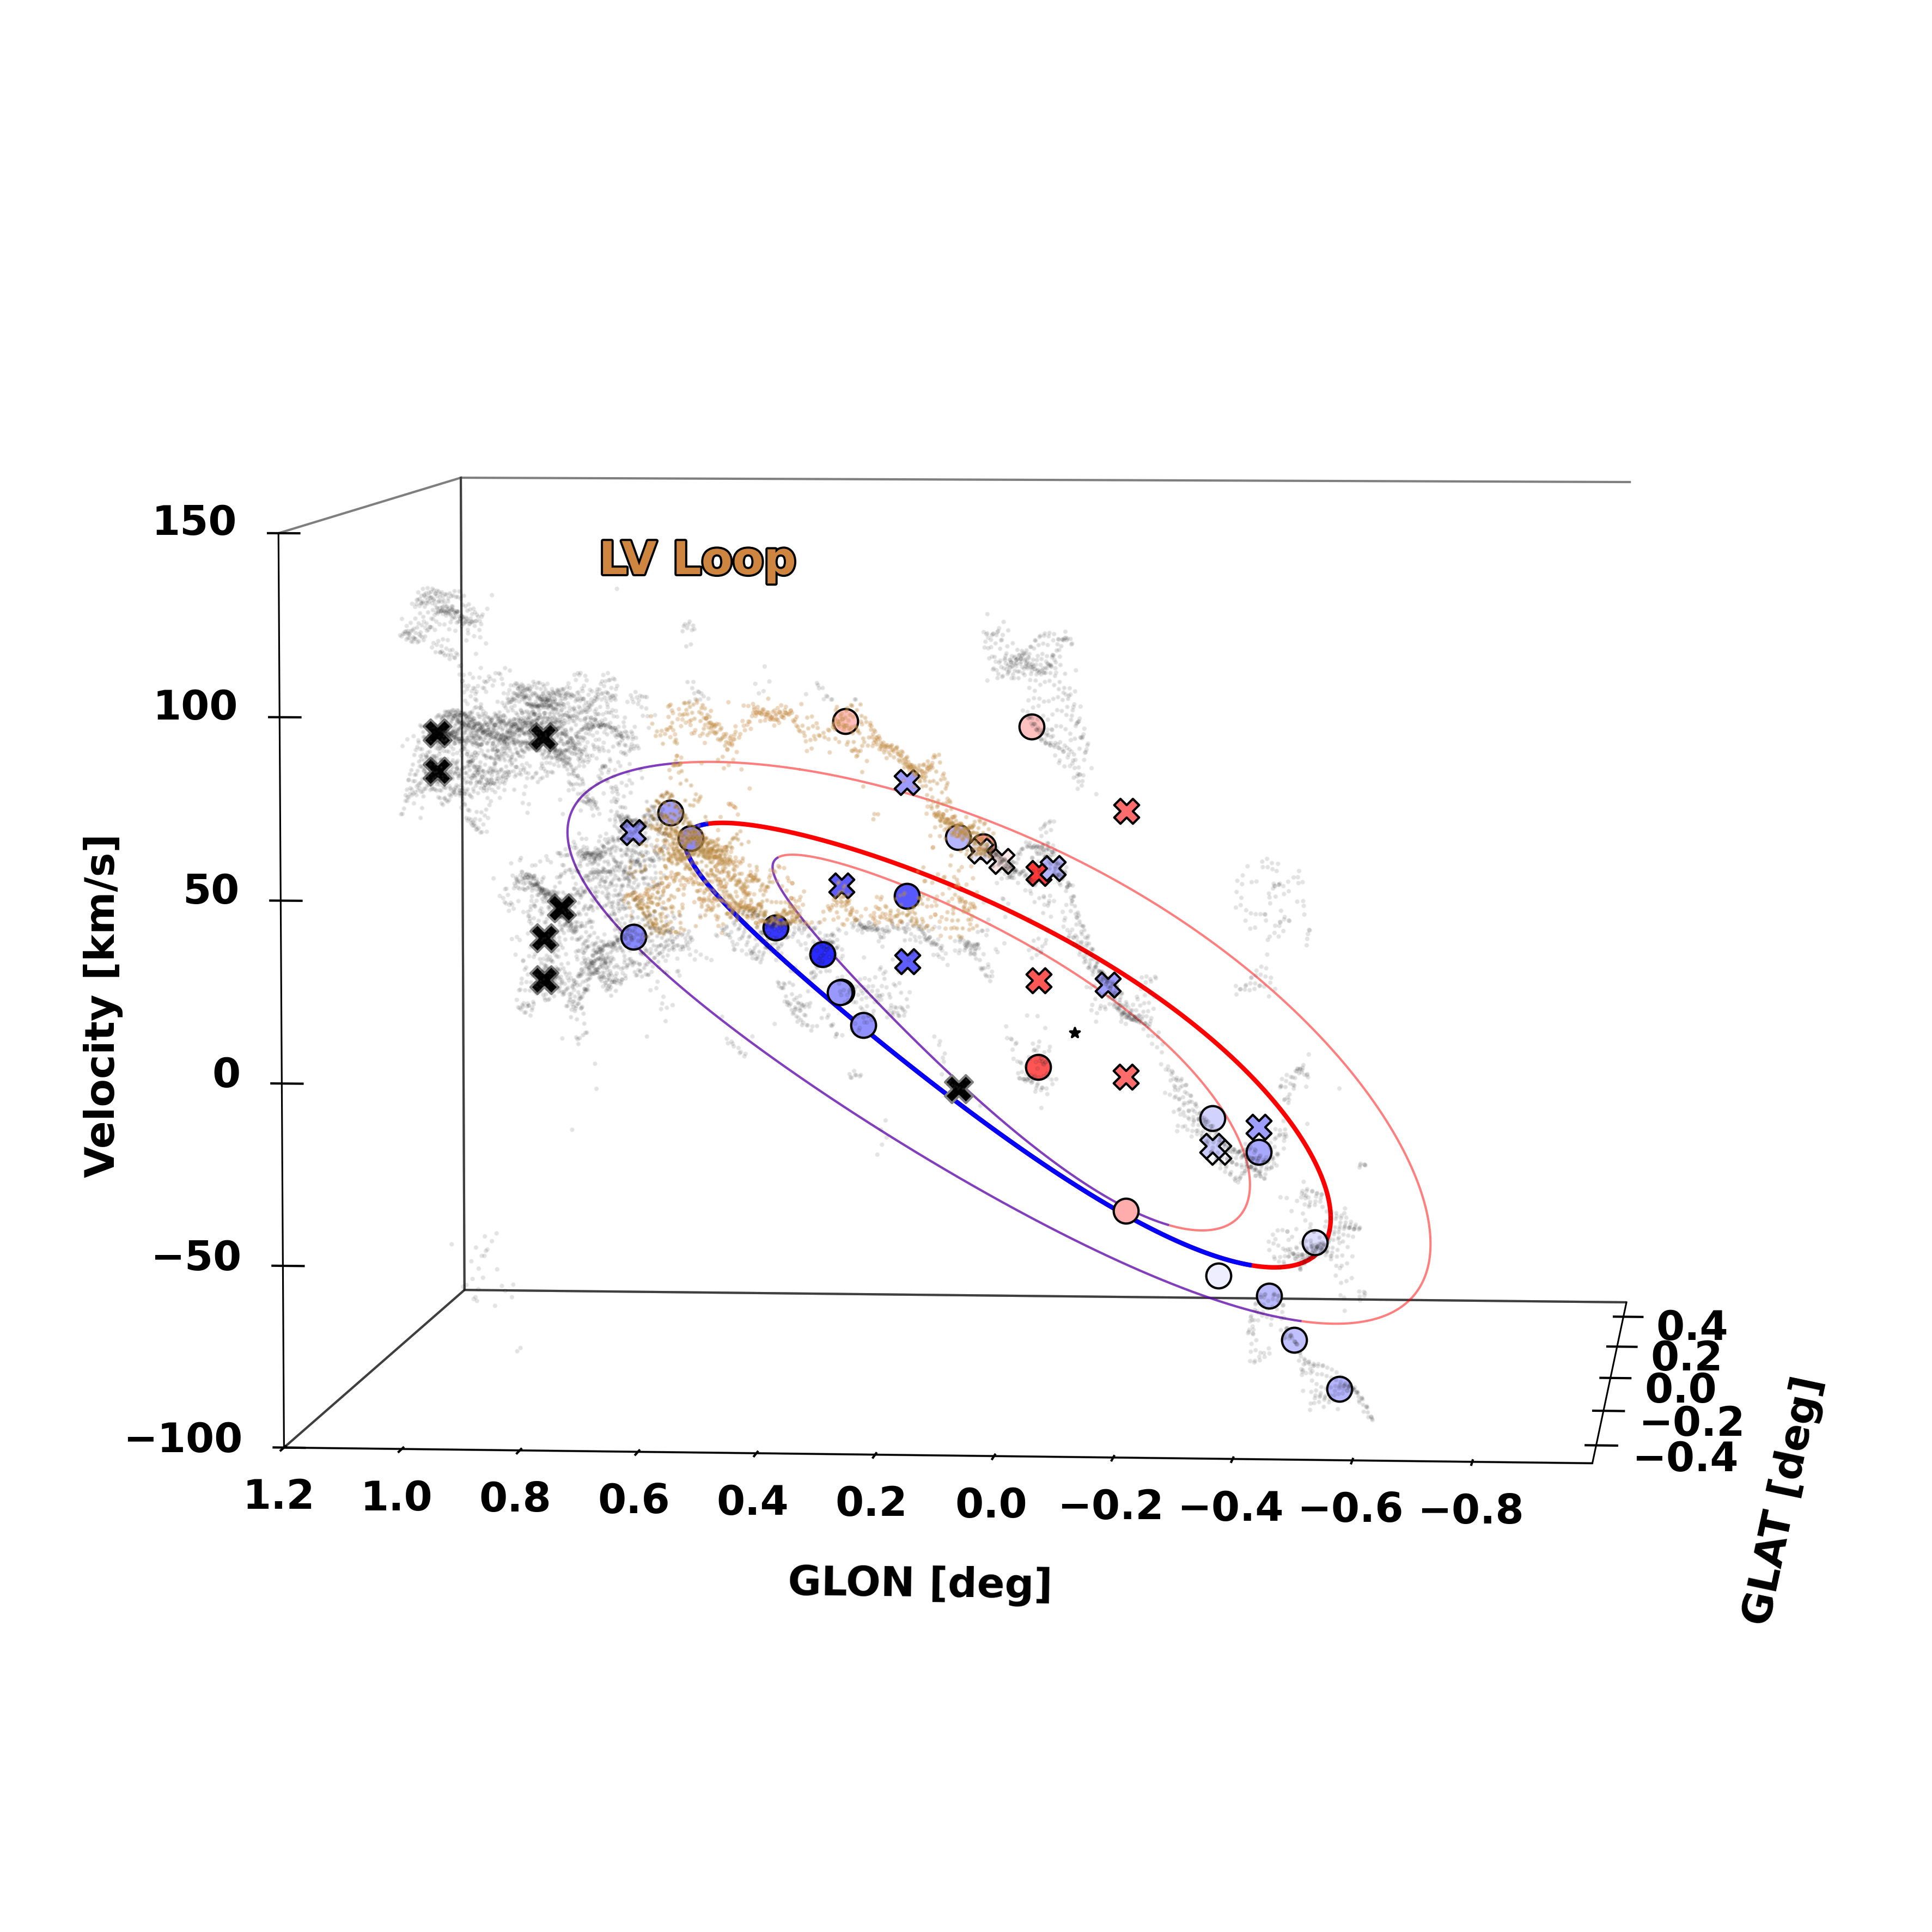

<Figure size 640x480 with 0 Axes>

In [140]:
fig = plt.figure(figsize=(15,15), dpi=300)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values


### scouse data, highlight the lv loop ###
lv_mask = (l>0.1) & (l<0.7) &  (v>30) &  (v<95)
n_lv_mask = ~lv_mask
ax.scatter(l[n_lv_mask], b[n_lv_mask], v[n_lv_mask], c=amp[n_lv_mask], cmap='Greys', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)

ax.scatter(l[lv_mask], b[lv_mask], v[lv_mask], c=amp[lv_mask], cmap='Greens', marker='o', s=1, facecolor='1', edgecolor='peru' ,norm=mpl.colors.LogNorm(), alpha=0.3)



ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*


back_ind, fore_ind = back_fore_ind(Rings_inner)
ax.plot(np.degrees(Rings_inner.l[back_ind[0:-1]]),np.degrees(Rings_inner.b[back_ind[0:-1]]), Rings_inner.vr[back_ind[0:-1]], ls='-', color='red', linewidth=1,  alpha=0.5)
ax.plot(np.degrees(Rings_inner.l[fore_ind[0:]]),np.degrees(Rings_inner.b[fore_ind[0:]]), Rings_inner.vr[fore_ind[0:]], ls='-', color='blue', linewidth=1,  alpha=0.5)


back_ind, fore_ind = back_fore_ind(Rings_avg)
ax.plot(np.degrees(Rings_avg.l[back_ind[0:-1]]),np.degrees(Rings_avg.b[back_ind[0:-1]]), Rings_avg.vr[back_ind[0:-1]], ls='-', color='red', linewidth=2, alpha=1)
ax.plot(np.degrees(Rings_avg.l[fore_ind[0:]]),np.degrees(Rings_avg.b[fore_ind[0:]]), Rings_avg.vr[fore_ind[0:]], ls='-', color='blue', linewidth=2,  alpha=1)


back_ind, fore_ind = back_fore_ind(Rings_outer)
ax.plot(np.degrees(Rings_outer.l[back_ind[0:-1]]),np.degrees(Rings_outer.b[back_ind[0:-1]]), Rings_outer.vr[back_ind[0:-1]], ls='-', color='red', linewidth=1, alpha=0.5)
ax.plot(np.degrees(Rings_outer.l[fore_ind[0:]]),np.degrees(Rings_outer.b[fore_ind[0:]]), Rings_outer.vr[fore_ind[0:]], ls='-', color='blue', linewidth=1,  alpha=0.5)







#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






ax.text(0.8, 0, 130, s= 'LV Loop',color='peru', fontsize=20,path_effects=[PathEffects.withStroke(linewidth=1.9, foreground="black")])


ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)

plt.savefig('./paper_items/Figs/LV_loop_3ellipse.png', bbox_inches='tight')

plt.show()
plt.clf()

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/3741496337.py:24: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/3741496337.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels=z_labels,


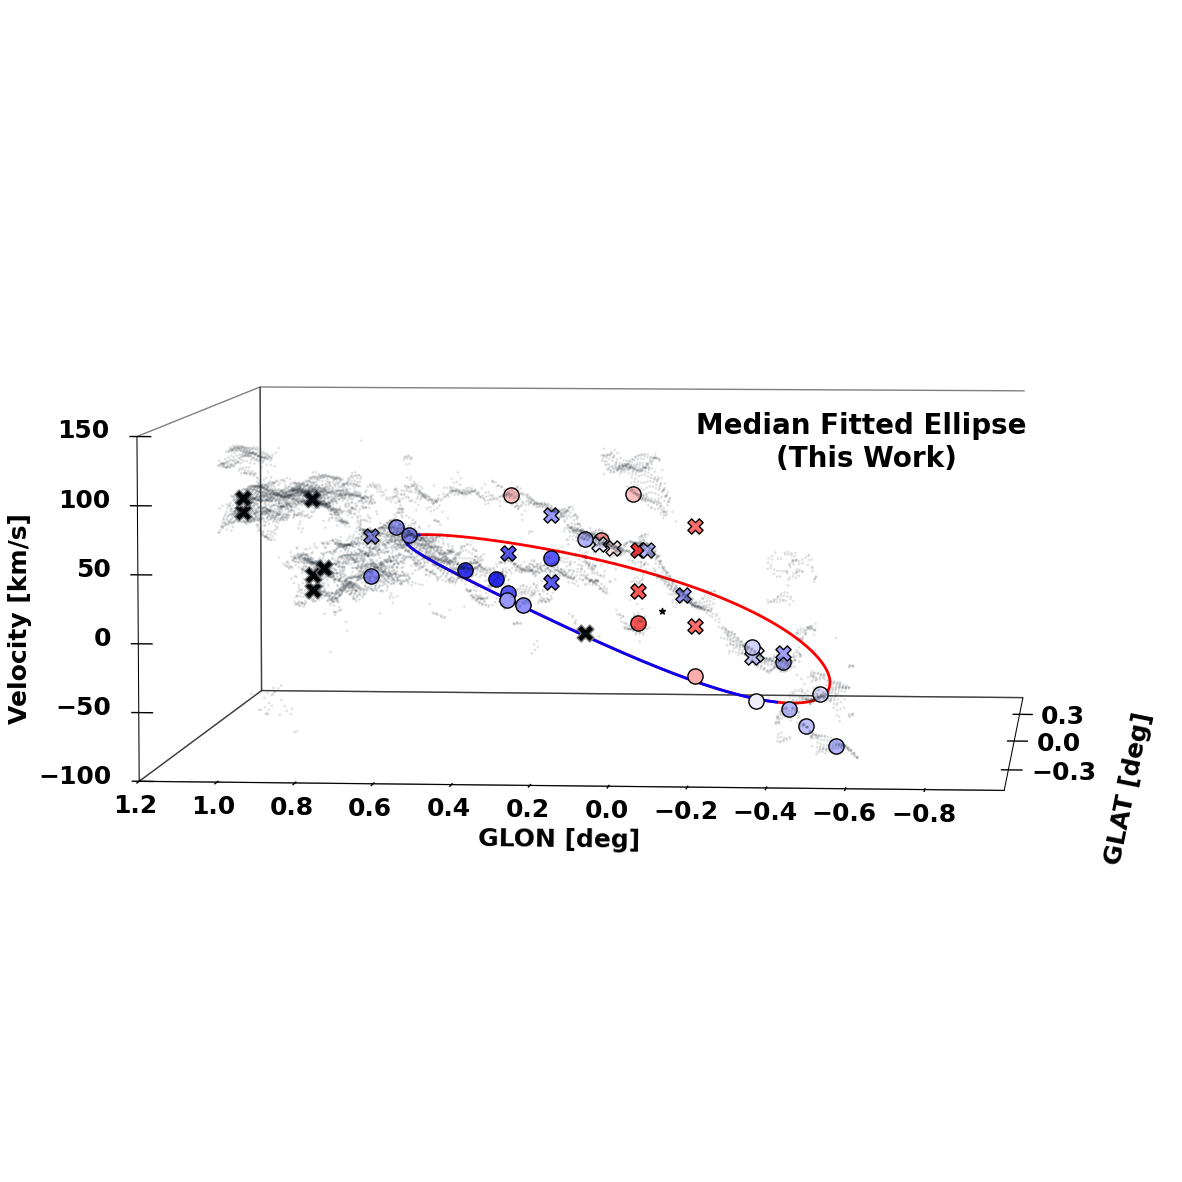

<Figure size 640x480 with 0 Axes>

In [41]:
fig = plt.figure(figsize=(15,15), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*


back_ind, fore_ind = back_fore_ind(Rings_avg)
ax.plot(np.degrees(Rings_avg.l[back_ind[0:-1]]),np.degrees(Rings_avg.b[back_ind[0:-1]]), Rings_avg.vr[back_ind[0:-1]], ls='-', color='red', linewidth=2, alpha=1)
ax.plot(np.degrees(Rings_avg.l[fore_ind[0:]]),np.degrees(Rings_avg.b[fore_ind[0:]]), Rings_avg.vr[fore_ind[0:]], ls='-', color='blue', linewidth=2,  alpha=1)







#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)



ax.text(0.-0.6, 0, 110, s= 'Median Fitted Ellipse \n(This Work)',color='k', ha='center',fontsize=20)



ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks(ticks = [-0.3, 0.0, 0.3])

b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)
ax.set_box_aspect((1, 1, 0.4))
plt.show()
plt.clf()

# SOFUE 3D 

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/4223258482.py:29: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/4223258482.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels=z_labels,


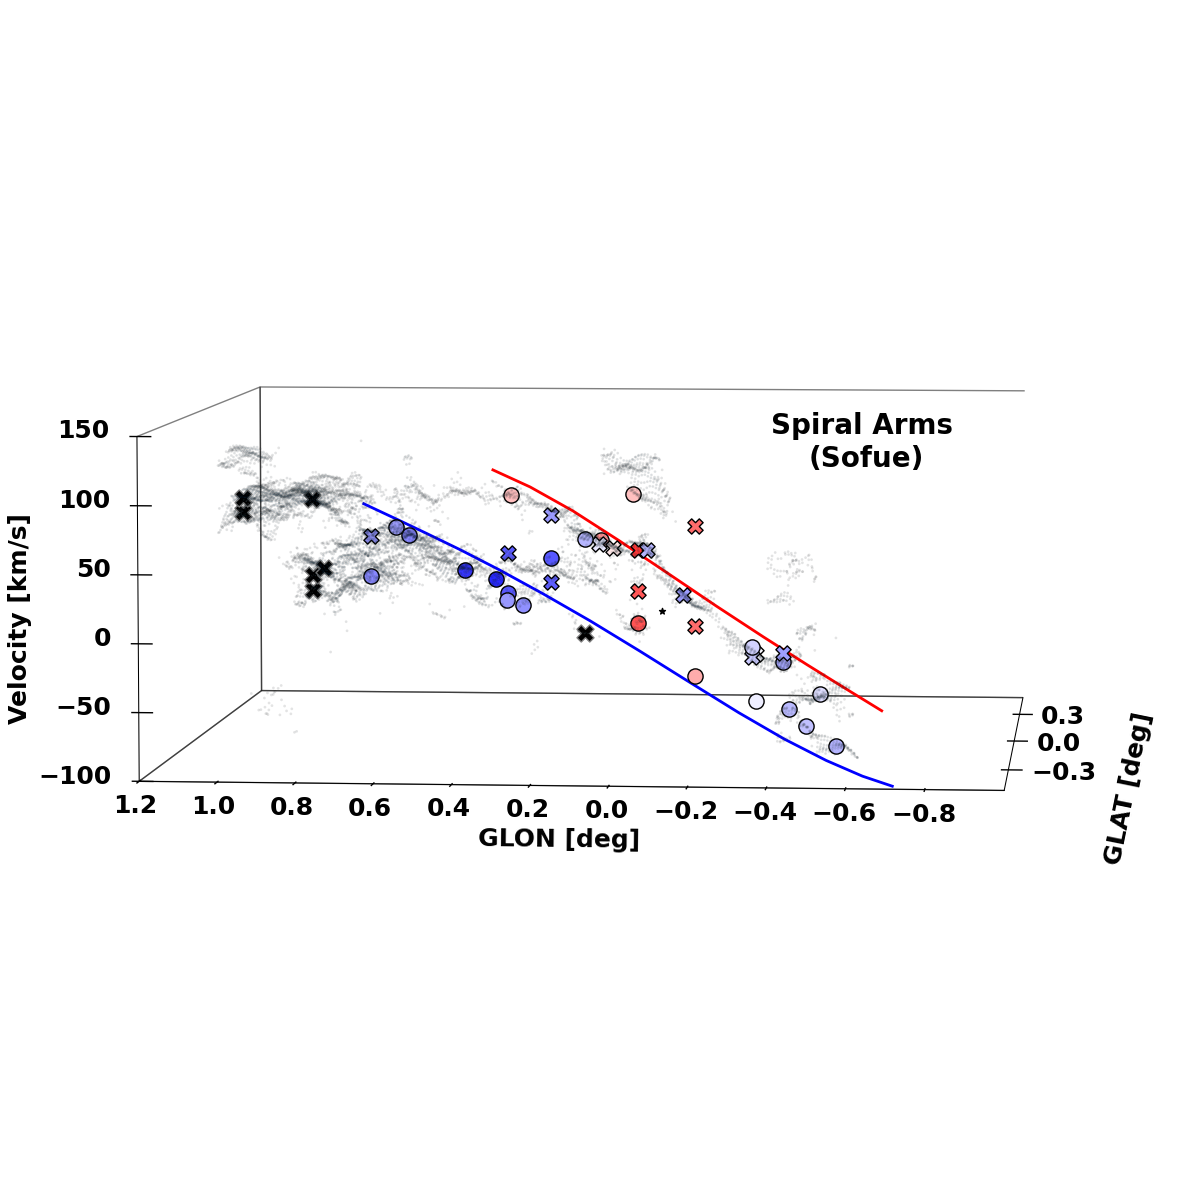

<Figure size 640x480 with 0 Axes>

In [42]:
fig = plt.figure(figsize=(15,15), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)

sofue1 = np.loadtxt('/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/sofue_lbv_arm1.txt', unpack=True)
sofue1_l, sofue1_b, sofue1_v = sofue1[0], sofue1[1], sofue1[2]
sofue2 = np.loadtxt('/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/sofue_lbv_arm2.txt', unpack=True)
sofue2_l, sofue2_b, sofue2_v = sofue2[0], sofue2[1], sofue2[2]


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(sofue1_l, sofue1_b, sofue1_v, ls='-', color='blue', linewidth=2, zorder=2)
ax.plot(sofue2_l, sofue2_b, sofue2_v, ls='-', color='red', linewidth=2, zorder=2)






#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


ax.text(0.-0.6, 0, 110, s= 'Spiral Arms \n(Sofue)',color='k', ha='center',fontsize=20)

ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks(ticks = [-0.3, 0.0, 0.3])

b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)
ax.set_box_aspect((1, 1, 0.4))
plt.show()
plt.clf()

# KDL 3D

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/2586245576.py:27: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_48682/2586245576.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels=z_labels,


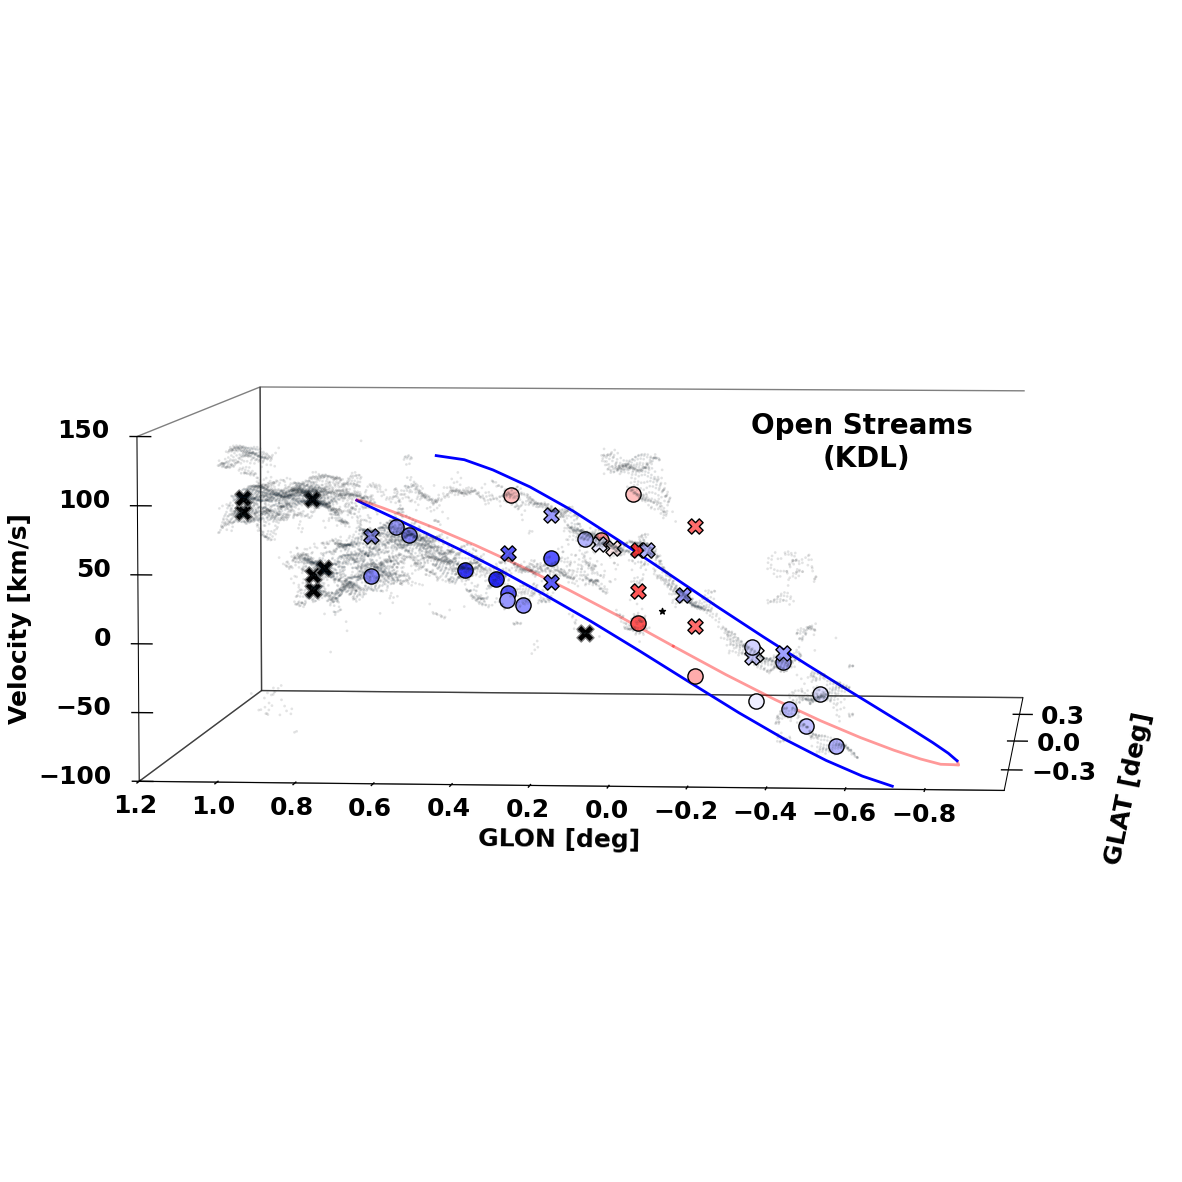

<Figure size 640x480 with 0 Axes>

In [43]:
fig = plt.figure(figsize=(15,15), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)

kdl = np.loadtxt('/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/kdl_lbv.txt', unpack=True)
lk, bk, vk = kdl[0], kdl[1], kdl[2]


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(lk[0:16], bk[0:16],vk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax.plot(lk[15:26], bk[15:26],vk[15:26] ,ls='-', color='red', linewidth=2, alpha=0.4)
ax.plot(lk[25:36], bk[25:36],vk[25:36] ,ls='-', color='red', linewidth=2, alpha=0.4)
ax.plot(lk[35:51], bk[35:51],vk[35:51] ,ls='-', color='blue', linewidth=2, zorder=2)




#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


ax.text(0.-0.6, 0, 110, s= 'Open Streams \n(KDL)',color='k', ha='center',fontsize=20)


ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks(ticks = [-0.3, 0.0, 0.3])

b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)
ax.set_box_aspect((1, 1, 0.4))
plt.show()
plt.clf()

# Molinari 3D

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_51858/493522294.py:27: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_51858/493522294.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels=z_labels,


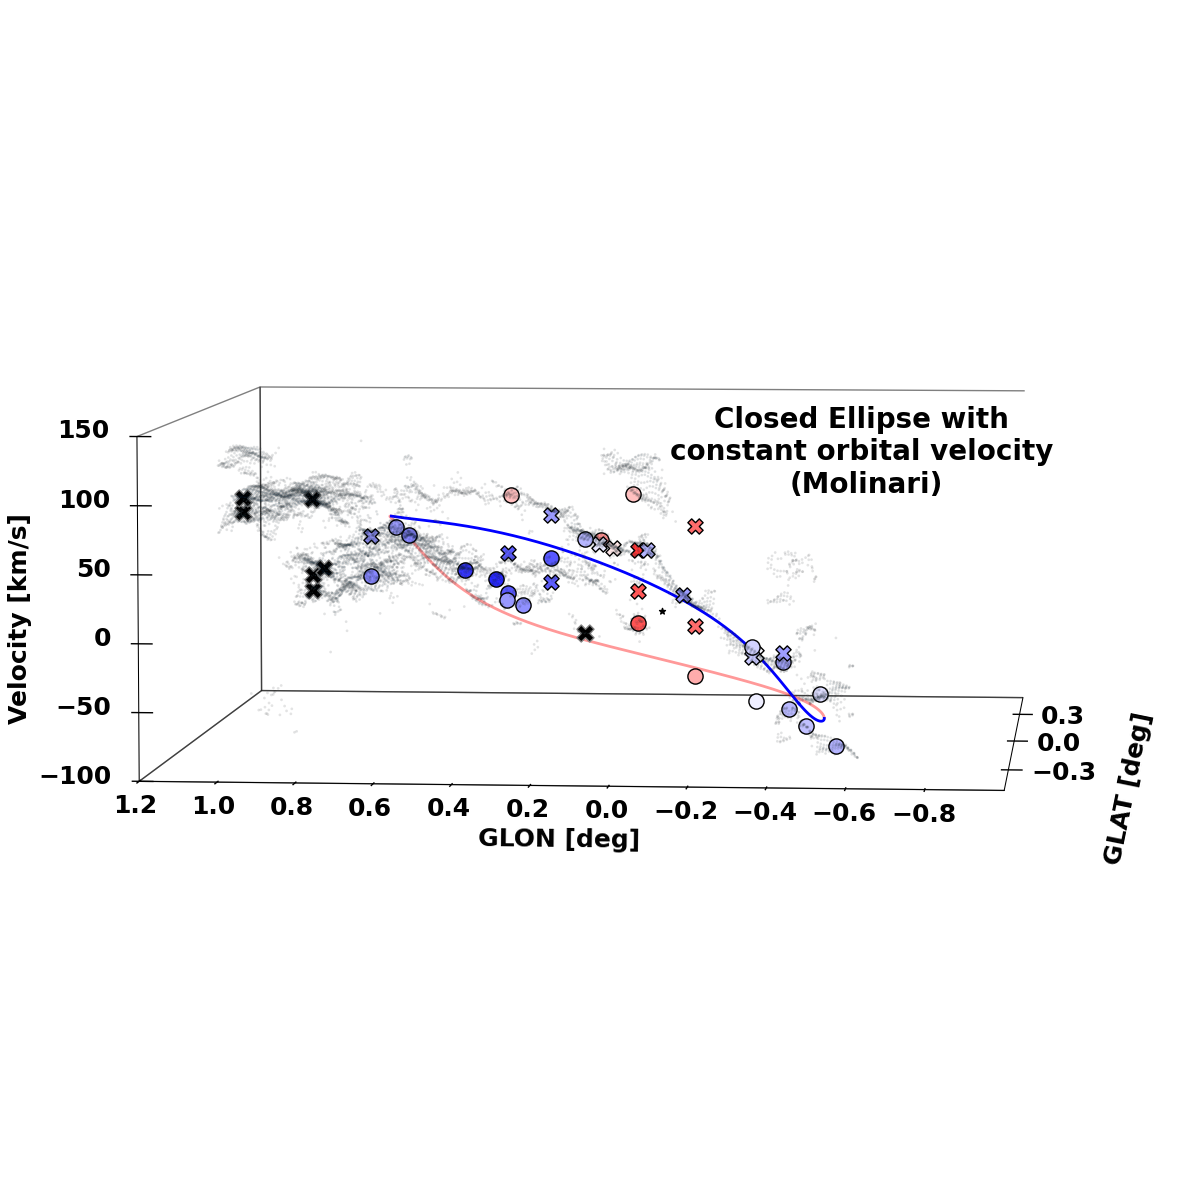

<Figure size 640x480 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(15,15), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
#ax.set_box_aspect(aspect=(2, 1, 1), zoom=1.4)

ml = np.loadtxt('/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/molinari_lbvlos.txt', unpack=True)
lk, bk, vk = ml[0], ml[1], ml[2]


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

l   = scouse_fits['l'].values
b   = scouse_fits['b'].values
v   = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

ax.scatter(l, b, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1)
ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(-1*lk[80:580], bk[80:580],vk[80:580] ,ls='-', color='red', linewidth=2, alpha=0.4)
ax.plot(-1*lk[0:80], bk[0:80],vk[0:80] ,ls='-', color='blue', linewidth=2, zorder=2)
ax.plot(-1*lk[581:], bk[581:],vk[581:] ,ls='-', color='blue', linewidth=2, zorder=2)


#Plot the points 
divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(0,len(plot_tab[:-3])):
    
    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
        alpha = 1.
    else:
        marker = 'o'
        alpha = 1.

    if plot_tab['NF_decision'][i] != 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, 
                    c=plot_post_tab['mu'][i], s=120, 
                    cmap=cmap, norm=divnorm, alpha = alpha)


    if plot_tab['NF_decision'][i] == 'nan':
        ax.scatter(plot_tab['l'][i],plot_tab['b'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)




ax.text(0.-0.6, 0, 90, s= 'Closed Ellipse with \nconstant orbital velocity \n(Molinari)',color='k', ha='center',fontsize=20)


ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_box_aspect((1, 1, 0.7))
ax.set_xlim(1.2,-1.0)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-100.,150.)

labelfontsize = 18
ax.set_xticks(ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks(ticks = [-0.3, 0.0, 0.3])

b_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=b_labels,
                   verticalalignment='baseline',
                   horizontalalignment='left')
z_labels = ax.get_zticklabels()
ax.set_zticklabels(labels=z_labels,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=labelfontsize)
ax.tick_params(axis='both', which='minor', labelsize=labelfontsize)

ax.set_xlabel('GLON [deg]', labelpad=30, fontsize=labelfontsize)
ax.set_ylabel('GLAT [deg]',  labelpad=40, fontsize=labelfontsize)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Velocity [km/s]', labelpad=30, rotation=90, fontsize=labelfontsize)
ax.set_box_aspect((1, 1, 0.4))
plt.show()
plt.clf()